In [121]:
#!/usr/bin/python
# updated DBR 02/2025 #

%matplotlib inline  

import os

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.family'] = 'Myriad Pro'  # Choose the desired font family (e.g., 'serif', 'sans-serif', 'monospace')
matplotlib.rcParams['font.size'] = 10  # Choose the desired font size

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
import scipy.stats as st

#ipython magic to make module autoreload
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_style("ticks")

#pull in the code to do the sims!
import ra_module
import clonesim_module as clmod

import scipy.optimize as opt #for power law fitting

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

colormap=cm.jet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
#read in ecology from past work for comparisons
outdf=pd.read_csv('data/clean/ecometrics_wprovirusrecalc.csv') #for comparing TCRs among different cohorts

#extra data for fitting metrics
TCRrho=pd.read_csv('data/clean/init_foldchg_rho.csv')
IPDAdf=pd.read_csv('data/clean/IPDArates.csv')
lamdf=pd.read_csv('data/clean/expcontr.csv')



In [102]:
#full data frame with fitting metrics

#CD4 levels
mCD4 = np.mean(outdf['CD4'].dropna())
sCD4 = np.std(outdf['CD4'].dropna())

#TCR rank abundance power law (over time)
mTCRal0 = np.mean(outdf[outdf['mo_post_ART']<12]['ali'].dropna().values)
sTCRal0 = np.std(outdf[outdf['mo_post_ART']<12]['ali'].dropna().values)
mTCRal1 = np.mean(outdf[(outdf['mo_post_ART']>12) & (outdf['mo_post_ART']<100)]['ali'].dropna().values)
sTCRal1 = np.std(outdf[(outdf['mo_post_ART']>12) & (outdf['mo_post_ART']<100)]['ali'].dropna().values)
mTCRal2 = np.mean(outdf[outdf['mo_post_ART']>100]['ali'].dropna().values)
sTCRal2 = np.std(outdf[outdf['mo_post_ART']>100]['ali'].dropna().values)

#HIV power law over time
mHIVal1 = np.mean(outdf[outdf['mo_post_ART']<30]['alpro'].dropna().values)
sHIVal1 = np.std(outdf[outdf['mo_post_ART']<30]['alpro'].dropna().values)
mHIVal2 = np.mean(outdf[outdf['mo_post_ART']>30]['alpro'].dropna().values)
sHIVal2 = np.std(outdf[outdf['mo_post_ART']>30]['alpro'].dropna().values)

#expansion/contraction distributions
mlame=np.mean(lamdf['lam_expand'])
slame=np.mean(lamdf['lam_expand'])
mlamc=np.mean(lamdf['lam_contract'])
slamc=np.mean(lamdf['lam_contract'])

#read in IPDA rates
mInt = IPDAdf['mean'].iloc[0]
sInt = IPDAdf['se'].iloc[0]
mDef = IPDAdf['mean'].iloc[1]
sDef = IPDAdf['se'].iloc[1]

#TCR fold changes
mrho=np.mean(TCRrho['init_foldchg_rho'])
srho=np.std(TCRrho['init_foldchg_rho'])

metric_list=['CD4 count',
             'TCR alpha t0','TCR alpha t1','TCR alpha t2',
             'HIV alpha t1','HIV alpha t2',
             'TCR lam expand','TCR lam contract',
             'Intact decay','Defective decay',
             'TCR correlation']

mean_list = [mCD4,mTCRal0,mTCRal1,mTCRal2,mHIVal1,mHIVal2,mlame,mlamc,mInt,mDef,mrho]
std_list = [sCD4,sTCRal0,sTCRal1,sTCRal2,sHIVal1,sHIVal2,slame,slamc,sInt,sDef,srho]

dfM = pd.DataFrame({'name':metric_list,'mean':mean_list,'std':std_list})

dfM

,name,mean,std
0,CD4 count,590.954545,199.302985
1,TCR alpha t0,0.473809,0.126596
2,TCR alpha t1,0.433132,0.098152
3,TCR alpha t2,0.506257,0.171211
4,HIV alpha t1,0.737379,0.389630
5,HIV alpha t2,1.273764,0.284946
6,TCR lam expand,-0.477750,-0.477750
7,TCR lam contract,-0.451298,-0.451298
8,Intact decay,-0.017419,0.005540
9,Defective decay,-0.007199,0.005339


In [103]:
#### fixed parameters across all models

c3=['tab:blue','tab:green','tab:red'] #colors for samples

dt=30
tF=365*10

Trescale=800

ss=int(1e4)
sH=int(100)

sample_times = [20,40,90]

In [125]:
#get best model

bestm=134

import pickle
with open('models.pkl', 'rb') as f:
    modeld = pickle.load(f)

model = modeld[bestm]

{'fn': '134',
 'dt': 30,
 'tF': 3650,
 'T0': 1000000,
 'm0': 'pwl',
 'Tmp': 0.8,
 'rm': 'const',
 'rmp': 0.8,
 'apr': 0.01,
 'ncr': 0,
 'aer': 0,
 'trd': 20000,
 'cov': 1,
 'pps': [3000.0, 800.0, 0],
 'pds': [0.0005776226504666211, 0.00023104906018664843, 0.001]}

In [119]:
#initialize the base model
#uniform T0 with T0 model param:100 (T0i), uniform proliferation, no reemergence, never redraw rates, no xi, full coverage

#HIV provirus proportions, from IPDA data, per million CD4
T0=1e6
cHIV = 3000*T0/1e6; 
cHIVint = 800*T0/1e6; 
cHIVsurv = 3#100*T0/1e6 #1/100 intact? total? have survival advantages?

#decay rates
xi_int = 0#np.log(2)/(40*30)
xi_def = 0#np.log(2)/(100*30)
zeta   = 0.001 #additional advantage, should basically balance out xi

fn='base'
model = { 'fn':fn,       #name for saving
          'dt':dt,        #time step, start monthly
          'tF':tF,       #sim length days
          'T0':int(T0),  #initial TCR size, needs to be an integer 
          'm0':'uni',     #type of initial condition distribution ['const','uni','exp','pwl']
          'Tmp':100,      #parameterize initial size distribution ['const','uni','exp','pwl']
          'rm':'uni',     #model for proliferation events, options: ['uni','exp','pwl','2phase']
          'rmp':0,        #parameterize distribution of proliferation rates disrtribution (a list if 2phase is chosen)
          'apr':0.01,     #avg prolif rate, per day, TCM rate
          'ncr':0,        #net clearance rate, balance for T cells, net = prolif - death
          'aer':0,        #emergence rate cells/day, new
          'trd':10000,      #time to redraw rates, if >tF not happen
          'cov':0,        #start with HIV fully covers clones
          'pps':[cHIV,cHIVint,cHIVsurv],      #provirus proportions
          'pds':[xi_int,xi_def,zeta]}     #provirus decay rates


In [120]:
#### use module to do the simulation ####

t,T = clmod.sim_clones(model) 

H,T,il = clmod.simHIV(t,T,model)

i_H,i_int,i_surv=il #list of indices


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_23268/243226846.py:40: RuntimeWarning: invalid value encountered in divide
  axs[3].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0.0)


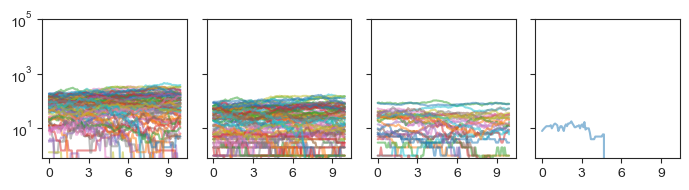

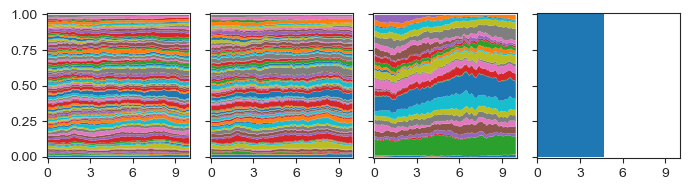

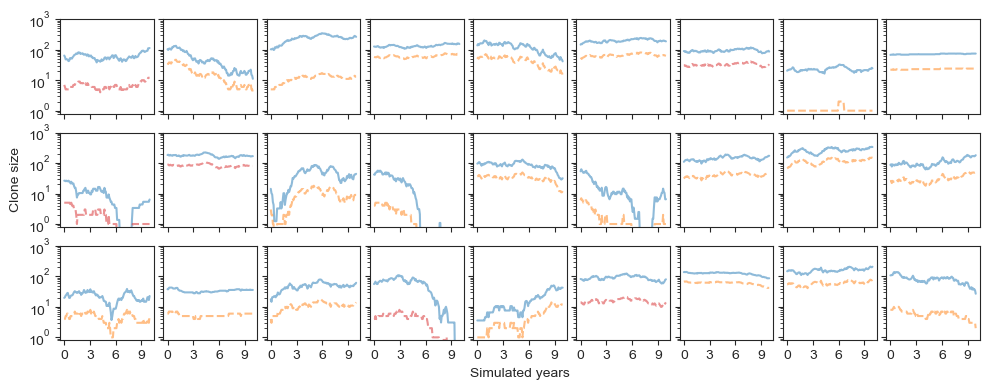

In [106]:
#examples of clone traces

fig,axs=plt.subplots(1,4,sharex=True,sharey=True,figsize=(7,2),)

#num_examples=100
num_examples=min([100,len(i_H)])
tplot=t/365 #years!

for j in range(num_examples):
    axs[0].semilogy(tplot,T[i_H[j],:],alpha=0.5)   
    axs[1].semilogy(tplot,H[i_H[j],:],alpha=0.5)   
for j in range(len(i_int)):
    axs[2].semilogy(tplot,H[i_int[j]],alpha=0.5)   
for j in range(len(i_surv)):
    axs[3].semilogy(tplot,H[i_surv[j]],alpha=0.5)   
axs[0].set_ylim([0.8,1e5])
#axs[1].set_ylim([0.8,1e3])
#axs[2].set_ylim([0.8,1e3])
#axs[3].set_ylim([0.8,1e3])
plt.xticks(np.arange(0,tF/365+1,3))

plt.tight_layout()
plt.savefig('figures/'+fn+'-traces.pdf')

## PROPORTIONS

fig,axs=plt.subplots(1,4,sharex=True,sharey=True,figsize=(7,2))

yT=T[H[:,30]>0,:]
axs[0].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0)

yT=H[H[:,30]>0,:]
axs[1].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0)

yT=H[i_int,:]
axs[2].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0.0)

if len(i_surv)>0:
    yT=H[i_surv,:]
    axs[3].stackplot(tplot,yT/np.sum(yT,axis=0),lw=0.0)

axs[0].set_xlim(-0.05,tF/365+0.05)
axs[0].set_ylim(-0.01,1.01)

plt.xticks(np.arange(0,tF/365+1,3))

plt.tight_layout()
plt.savefig('figures/'+fn+'-tracesprop.pdf')

###  examples of fractions infected

#find some TCR clonotypes that persist at leasst 50mo
#persistentTCR = np.where(T[iTCRl,50]>1)[0]

#find some HIV clonotypes that persist
persistentHIV = np.where(H[:,30]>1)[0]

i=0
nx=3
ny=9
fig,axs=plt.subplots(nx,ny,sharex=True,sharey=True,figsize=(10,4),)
for j in range(ny*nx):
    jj=i_H[j]
    #jj=persistentHIV[j]
    
    cz='tab:orange'
    if jj in i_int:
        cz='tab:red'
    if jj in i_surv:
        cz='tab:purple'
    ax=axs[j%nx][int(j/nx)]
    ax.plot(tplot,T[jj,:],color='tab:blue',alpha=0.5,label='TCRβ')   #the index among TCR
    ax.plot(tplot,H[jj,:],color=cz,alpha=0.5,label='HIV',ls='--')   
    #ax.fill_between(t/30,np.ones(len(t))*0.1,T[iTCRl[jj],:]+0.1,color='tab:blue',alpha=1,label='TCRb')   #the index among TCR
    #ax.fill_between(t/30,np.ones(len(t))*0.1,H[jj,:]+0.1,color='tab:orange',alpha=1,label='HIV')   #the index among TCR

ax.set_ylim([0.8,1e3])
ax.set_xticks(np.arange(0,tF/365+1,3))
axs[1][0].set_ylabel('Clone size')
#axs[0][0].legend()
axs[2][4].set_xlabel('Simulated years')

plt.semilogy()
plt.tight_layout()
plt.subplots_adjust(hspace = .2)
plt.subplots_adjust(wspace = 0.1)

plt.savefig('figures/'+fn+'-bluepurp.svg')


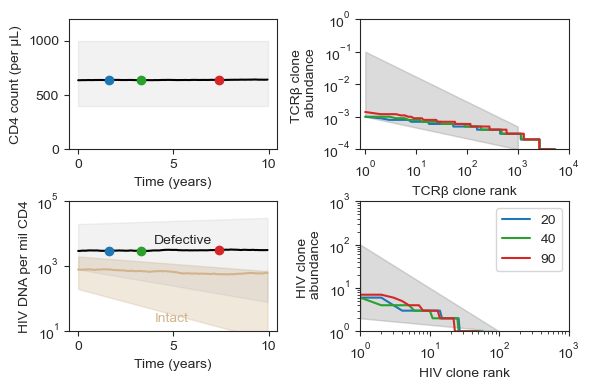

In [107]:
#rank abundance plots

plt.figure(figsize=(6,4))

az=0.1

#total TCR
plt.subplot(221)
plt.plot(tplot,np.sum(T,axis=0)/Trescale,color='k') #
plt.fill_between(tplot,400*np.ones(len(t)),1000*np.ones(len(t)),color='gray',alpha=az)

Dl=[] #list for Hill exponents
for i,iit in enumerate(sample_times):
    
    plt.subplot(221)    
    plt.plot(tplot[iit],np.nansum(T[:,iit])/Trescale,marker='o',ls='',markersize=6,color=c3[i])
    plt.xlabel('Time (years)')
    plt.ylabel('CD4 count (per µL)')  
    plt.ylim([0,1200])

    #rank abundnace for TCR
    r,pars,a,RN,D1,D2 = clmod.compute_ecology(unsorted_abunds=T[:,iit],sample_size=ss)
    Dl.append([RN,D1,D2])
    
    plt.subplot(222)
    plt.loglog(r,pars,label=iit,color=c3[i])
    plt.xlabel('TCRβ clone rank')
    plt.yticks(np.logspace(-4,0,5))
    plt.xticks([1,10,100,1e3,1e4])
    plt.ylabel('TCRβ clone \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,1e3],[1e-1,5e-4],[1e-3,1e-4],color='gray',alpha=az)
    
#plt.legend()
plt.xlim([0.8,1e4])
plt.ylim([1e-4,1])

#HIV total sizes
plt.subplot(223)
plt.plot(tplot,np.sum(H,axis=0),color='k',label='total')
plt.semilogy(tplot,np.sum(H[i_int],axis=0),color='tan',label='intact')
#plt.semilogy(tplot,np.sum(H[iTCRlsurv],axis=0),color='tab:purple',label='survival',alpha=0.3)

#decay rate bands, needs to be in years (for tplot)
thI1=np.log(2)/(23/12); thI2=np.log(2)/(80/12)
thD1=np.log(2)/(36/12); thD2=-np.log(2)/(190/12)
plt.fill_between(tplot,200*np.exp(-tplot*thI1),2000*np.exp(-tplot*thI2),color='tan',alpha=0.3)
plt.fill_between(tplot,800*np.exp(-tplot*thD1),20000*np.exp(-tplot*thD2),color='gray',alpha=az)

#plt.legend(loc=3)
plt.xlabel('Time (years)')
plt.ylabel('HIV DNA per mil CD4')
plt.ylim([10,1e5])
plt.annotate('Defective',[4,5e3])
plt.annotate('Intact',[4,20],color='tan')

HDl=[]
for i,iit in enumerate(sample_times):
    plt.subplot(223)
    
    plt.plot(tplot[iit],np.sum(H[:,iit],axis=0),marker='o',ls='',color=c3[i],markersize=6)
    r,pars,a,RN,D1,D2 = clmod.compute_ecology(unsorted_abunds=H[H[:,iit]>0,iit],sample_size=sH)

    HDl.append([RN,D1,D2])

    #HIV model rank abundances
    plt.subplot(224)
    plt.loglog(r,a,label=iit,color=c3[i])
    plt.xlabel('HIV clone rank')
    plt.ylabel('HIV clone \n abundance')
    
    #plot comparison data (just use high and low from Fig 1 TCR rank abundances)
    plt.fill_between([1,100],[100,1],[2,1],color='gray',alpha=az)

plt.xlim([1,1e3])
plt.ylim([1,1e3])
plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.4)

plt.savefig('figures/'+fn+'-ras.pdf')


In [108]:
#extra functions for ecology (for now not in other file because of tricky fitting passing)

def calc_ecol(rs):
    l=rs[rs>0] #just keep nonzero
    R=len(l);  
    r=np.arange(R)+1
    a=-np.sort(-l)
    N=np.sum(a)
    pars=a/N
    cpa=np.cumsum(pars)
    
    D1=np.exp(-np.sum(pars*np.log(pars))) 
    D2=1/np.sum(pars**2)
    
    maxclone=a[0]/N
    
    top10clones=np.sum(a[:10])/N
    
    clonalf=np.sum(a[a>1])/N
    
    return r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf

def calc_ecol_simple(rs):
    l=rs[rs>0] #just keep nonzero
    R=len(l);  
    r=np.arange(R)+1
    a=-np.sort(-l)
    N=np.sum(a)
    pars=a/N
    cpa=np.cumsum(pars)
    
    D1=np.exp(-np.sum(pars*np.log(pars))) 
    D2=1/np.sum(pars**2)
    
    return R/N,D1/N,D2/N

#single power law
def pwl1(xx):
    al1=xx
    model_pa= r**-al1
    return model_pa/np.sum(model_pa)

#2 phase power law
def pwl2(xx):    
    al1,al2,psi=xx
    model_pa= r**-al1 + 1/psi*r**-al2
    return model_pa/np.sum(model_pa)
        
#calculate error for distribution, species abundance distribution
def SAD_error(xx):
    
    if dist_name=='pwl1':
        model_pa=pwl1(xx)
        
    if dist_name=='pwl2':
        model_pa=pwl2(xx)
           
    RMS = np.sqrt(np.mean((cpa[:maxr]-np.cumsum(model_pa[:maxr]))**2))
    #KS = np.max(cpa[:maxr]-np.cumsum(model_pa[:maxr]))
    #error=RMS
    return RMS

#had ried other models in past... check older code

In [109]:
#start the scoring!!
last_x=10

#CD4
Trescale = 800 #to get to uL
CD4 = np.nansum(T[:,iit])/Trescale

#TCRalpha

ss=int(1e4) #TCR sample size
sH=int(100) #HIV sample size

tpts = [10,25,90] #essentially in months (given dt),

al_TCR=[]
for iit in tpts:
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(T[:,iit]) #run this to sort etc
    rs = np.random.multinomial(n=ss,pvals=pars) #resampled abundance
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(rs) #now run again for actual fitting
    maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed
    dist_name='pwl1'
    res = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                           bounds=[[0.01,2.]], method='L-BFGS-B')
    al_TCR.append(res.x[0])

#HIV provirus fitting
al_H=[]
for iit in tpts[1:]:
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(H[:,iit]) #run this to sort etc, on HIV clones
    rs = np.random.multinomial(n=sH,pvals=pars) #resampled abundance (HIV size)
    r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=calc_ecol(rs) #now run again for actual fitting

    fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=a,R=10**6,max_al=2)
    al=fit_al[np.argmin(fit_score[0])]
    al_H.append(al)
    
    
#TCR fold change metrics from t1>t2
binz=np.arange(0,30,1)+1

T1=T[:,tpts[1]]; T2=T[:,tpts[2]]

T1z = T1[(T1>0) & (T2>0)]; T2z = T2[(T1>0) & (T2>0)] #drop zeros

ratios=T2z/T1z #size t1 vs change in size

rho = st.spearmanr(T1z,ratios)[1]

expands=ratios[ratios>1]
contracts=1/ratios[ratios<1]

ce,xe = np.histogram(expands,bins=binz,density=True)
cc,xc = np.histogram(contracts,bins=binz,density=True)

#deal with nan
#ce[ce==0]=np.min(ce[ce>0])
#cc[cc==0]=np.min(cc[cc>0])

fit_lame, fit_y0 = np.polyfit(xe[:last_x],np.log(ce[:last_x]),1)
fit_lamc, fit_y0 = np.polyfit(xe[:last_x],np.log(cc[:last_x]),1)

#IPDA

Htot=np.sum(H,axis=0)
Hint=np.sum(H[i_int],axis=0)
Hdef=Htot-Hint

thI = np.polyfit(t/30,np.log(Hint),1)[0]
thD = np.polyfit(t/30,np.log(Htot),1)[0]



/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_23268/1466879483.py:59: RuntimeWarning: divide by zero encountered in log
  fit_lame, fit_y0 = np.polyfit(xe[:last_x],np.log(ce[:last_x]),1)


In [110]:
dfM[model['fn']]=[CD4]+al_TCR+al_H+[fit_lame,fit_lamc,thI,thD,rho]

dfM

,name,mean,std,base
0,CD4 count,590.954545,199.302985,640.012425
1,TCR alpha t0,0.473809,0.126596,0.423093
2,TCR alpha t1,0.433132,0.098152,0.434111
3,TCR alpha t2,0.506257,0.171211,0.467681
4,HIV alpha t1,0.737379,0.389630,1.176552
5,HIV alpha t2,1.273764,0.284946,1.176552
6,TCR lam expand,-0.477750,-0.477750,NaN
7,TCR lam contract,-0.451298,-0.451298,-0.484307
8,Intact decay,-0.017419,0.005540,-0.003067
9,Defective decay,-0.007199,0.005339,0.000560


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_23268/605636555.py:5: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(tplot,H[i,:]/T[i,:],color='tab:orange',alpha=0.05)
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_23268/605636555.py:7: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(tplot,H[i,:]/T[i,:],color='tab:red',alpha=0.05)
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_23268/605636555.py:9: RuntimeWarning: invalid value encountered in divide
  axs[2].plot(tplot,H[i,:]/T[i,:],color='tab:purple',alpha=0.1)


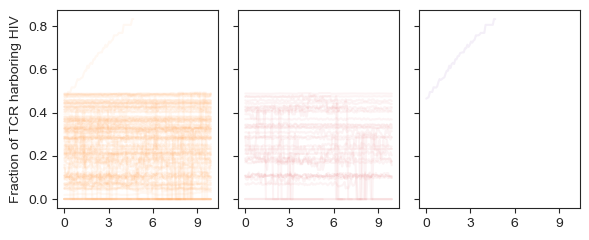

In [111]:
#show coverage fraction by type
fig,axs=plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,2.5))

for i in i_H:
    axs[0].plot(tplot,H[i,:]/T[i,:],color='tab:orange',alpha=0.05)
for i in i_int:
    axs[1].plot(tplot,H[i,:]/T[i,:],color='tab:red',alpha=0.05)
for i in i_surv:
    axs[2].plot(tplot,H[i,:]/T[i,:],color='tab:purple',alpha=0.1)
axs[2].set_xticks(np.arange(0,tF/365+1,3))
axs[0].set_ylabel('Fraction of TCR harboring HIV')

plt.tight_layout()
plt.savefig('figures/'+fn+'-HIVfractions.pdf')


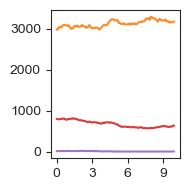

In [112]:
#show specific type kinetics

plt.figure(figsize=(2,2))
plt.plot(tplot,np.sum(H[i_H,:],axis=0),color='tab:orange',alpha=0.9,label='Defective')
plt.plot(tplot,np.sum(H[i_int,:],axis=0),color='tab:red',alpha=0.9,label='Intact')
plt.plot(tplot,np.sum(H[i_surv,:],axis=0),color='tab:purple',alpha=0.9,label='Survival')
#plt.ylabel('Simulated copies')
#plt.xlabel('Simulated years')
#plt.legend()
plt.xticks(np.arange(0,tF/365+1,3))
plt.tight_layout()
plt.savefig('figures/'+fn+'-HIVtypes.svg')


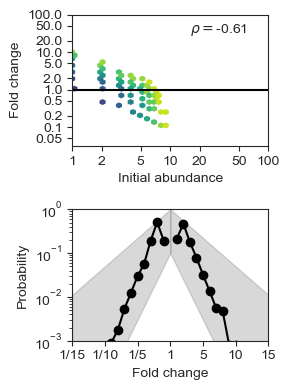

In [118]:
### TCR clone dynamics plots

#now calculate clone shifts/fold expansions etc to mimic data
t1=sample_times[1]; t2=sample_times[2]

rs1 = np.random.multinomial(n=ss,pvals=T[:,t1]/np.sum(T[:,t1])) #resampled abundance
rs2 = np.random.multinomial(n=ss,pvals=T[:,t2]/np.sum(T[:,t2])) #resampled abundance

#drop zeros
T1z = rs1[(rs1>0) & (rs2>0)]
T2z = rs2[(rs1>0) & (rs2>0)]

#size t1 vs change in size
ratios=T2z/T1z

expands=ratios[ratios>1]
contracts=ratios[ratios<1]

plt.figure(figsize=(3,4))

plt.subplot(211)
plt.hexbin(np.log10(T1z),np.log10(T2z/T1z),gridsize=20,cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=3000)
plt.axhline(0,ls='-',color='black')
plt.xlabel('Initial abundance')
plt.ylabel('Fold change')
plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
plt.ylim([-1.5,2])
plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([0,2])
plt.annotate(r'$\rho=$'+str(np.round(st.spearmanr(T1z,ratios)[0],2)),[1.2,1.5])

#fit the expansion distributions
last_x = 10 #how far to go out for fits
plt.subplot(212)
for j in range(2):

    if j==0:
        pdist = expands
        tn='expand'
        binz=np.arange(0,26)+1
        ecs=1
    if j==1:
        pdist = 1/contracts
        tn='contract'
        binz=np.arange(0,26)+1
        ecs=-1

    c,x = np.histogram(pdist,bins=binz,density=True)
    plt.plot(ecs*x[:-1],c,marker='o',ls='-',color='k',label=tn)
    xx=np.linspace(0,15,100)
    plt.fill_between(ecs*xx,0.1*np.exp(-0.7*xx),1*np.exp(-0.3*xx),color='gray',alpha=0.3)
  
    #plt.legend()
    plt.semilogy()
    plt.ylim([1e-3,1])
    plt.ylabel('Probability')
    plt.xlabel('Fold change')
    plt.xticks(np.linspace(-20,20,9),['1/20','1/15','1/10','1/5','1','5','10','15','20'])
    plt.xlim([-15,15])

plt.tight_layout()
plt.savefig('figures/'+fn+'-foldchanges.svg')


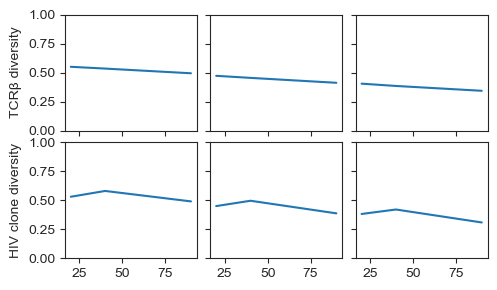

In [115]:
#normalized Hill coefficients, now with violin plots

fig,axs=plt.subplots(2,3,sharex=True,sharey=True,figsize=(5,3))

m3=['o','s','>']
for i in range(3):
    m=['R','D1','D2'][i]

    axs[0][i].plot(sample_times,np.array(Dl)[:,i]/ss)#,c=c3)
    axs[1][i].plot(sample_times,np.array(HDl)[:,i]/sH)#,c=c3)#,marker=m3)
    
axs[0][0].set_ylabel('TCRβ diversity')
axs[1][0].set_ylabel('HIV clone diversity')
#axs[1][0].set_xticks([1],[])#,['Model (dots) \n vs Experiment (shading)'])

axs[0][0].set_ylim([0,1])
plt.tight_layout()
plt.subplots_adjust(hspace = .1)
plt.subplots_adjust(wspace = .1)
plt.savefig('figures/'+fn+'-sim-ecometrics.pdf')


In [116]:
print(xi_def,'per day means % defective clearance due to selection',xi_def/(xi_def+apr)*100)

NameError: name 'apr' is not defined

In [117]:
print(xi_int,'per day means % intact clearance due to selection',xi_int/(xi_int+apr)*100)

NameError: name 'apr' is not defined